In [7]:


##60% of data was randomly chosen to allow the csv to be uploaded to GitHub

import pandas as pd
import requests
import io
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
%matplotlib inline
    
# Downloading the csv file from  GitHub account


url1 = "https://raw.githubusercontent.com/docju/CyclingData/main/2019%20-%2001.csv"
download1 = requests.get(url1).content

df1 = pd.read_csv(io.StringIO(download1.decode('utf-8')))

url2 = "https://raw.githubusercontent.com/docju/CyclingData/main/2019%20-%2002.csv"
download2 = requests.get(url2).content

df2 = pd.read_csv(io.StringIO(download2.decode('utf-8')))

url3 = "https://raw.githubusercontent.com/docju/CyclingData/main/2019%20-%2003.csv"
download3 = requests.get(url3).content

df3 = pd.read_csv(io.StringIO(download3.decode('utf-8')))

url4 = "https://raw.githubusercontent.com/docju/CyclingData/main/2019%20-%2004.csv"
download4 = requests.get(url4).content

df4 = pd.read_csv(io.StringIO(download4.decode('utf-8')))

url5 = "https://raw.githubusercontent.com/docju/CyclingData/main/2019%20-%2003.csv"
download5 = requests.get(url5).content

df5 = pd.read_csv(io.StringIO(download5.decode('utf-8')))

df=pd.concat([df1,df2,df3,df4,df5])

df.head()

,month,trip_duration_sec,start_station_id,start_station_name,end_station_id,end_station_name,bike_id,user_type,member_birth_year,member_gender
0,January,80825,229.0,Foothill Blvd at 42nd Ave,196.0,Grand Ave at Perkins St,4861,Subscriber,1989.0,Male
1,January,65900,4.0,Cyril Magnin St at Ellis St,134.0,Valencia St at 24th St,5506,Subscriber,1989.0,Male
2,January,62633,245.0,Downtown Berkeley BART,157.0,65th St at Hollis St,2717,Customer,1965.0,Female
3,January,44680,85.0,Church St at Duboce Ave,53.0,Grove St at Divisadero,4557,Customer,1974.0,Male
4,January,60709,16.0,Steuart St at Market St,28.0,The Embarcadero at Bryant St,2100,Customer,NaN,NaN


Find the types of variable and describe the Numeric ones

In [10]:
print(df.shape)

##1127203 rows, 10 columns

df.dtypes
##create list of categorial variables
cat_df = df.select_dtypes(include=['object']).copy()
cat_columns=list(cat_df.columns.values)

print(len(cat_columns)) ## 5 categorical columns
##create list of numeric variables
num_df= df.select_dtypes(include=['float','integer']).copy()
num_columns=list(num_df.columns.values)
print(len(num_columns)) ## 5 numerical columns, of which 3 could be considered ID variables

df.describe()

(1127203, 10)
5
5


,trip_duration_sec,start_station_id,end_station_id,bike_id,member_birth_year
count,1.127203e+06,1.126252e+06,1.126252e+06,1.127203e+06,1.074573e+06
mean,7.837612e+02,1.395562e+02,1.380771e+02,4.428058e+03,1.984790e+03
std,1.940237e+03,1.140981e+02,1.140545e+02,1.853062e+03,1.006524e+01
min,6.100000e+01,3.000000e+00,3.000000e+00,1.100000e+01,1.878000e+03
25%,3.370000e+02,4.600000e+01,4.400000e+01,3.233000e+03,1.980000e+03
50%,5.380000e+02,1.040000e+02,1.000000e+02,4.982000e+03,1.987000e+03
75%,8.430000e+02,2.390000e+02,2.380000e+02,5.819000e+03,1.992000e+03
max,8.611400e+04,4.200000e+02,4.200000e+02,7.108000e+03,2.001000e+03


Find the proportion of missing values

In [12]:
df.isna().mean()


month                 0.000000
trip_duration_sec     0.000000
start_station_id      0.000844
start_station_name    0.000844
end_station_id        0.000844
end_station_name      0.000844
bike_id               0.000000
user_type             0.000000
member_birth_year     0.046691
member_gender         0.046688
dtype: float64

This looks like there are not many rows with missing values. We can reasonably drop rows with missing values

In [57]:
no_na=df.dropna().copy()

print(len(no_na)) ##1073632 rows remain

print(len(no_na)/len(df)) ##95% of original data remains

##

1073632
0.9524743990212943


What is the distribution of trip duration and birth year?

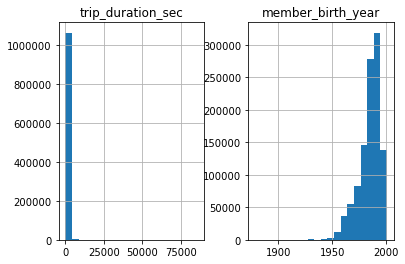

In [23]:
no_na[['trip_duration_sec', 'member_birth_year']].hist(bins=20);
## Results show outliers in trip duration in seconds and maybe some bad data in birth year where there are people born before 1900

In [58]:
 no_na[['trip_duration_sec']].sort_values(['trip_duration_sec'], 
                                             ascending=[False])
## The top values for trip duration correspond to a 24 hour period. Similarly, the lowest values are 61 seconds, which suggests either a very short trip or some kind of error

,trip_duration_sec
12667,86114
70083,85496
230332,84908
230332,84908
223092,84792
...,...
122184,61
193289,61
205762,61
48592,61


Investigate these unusual looking values for trip duration- first the large ones

In [62]:
## Get the length of trip in hours
no_na['trip_duration_hr'] = round(no_na['trip_duration_sec']/3600)

##We can see that 99% of trips are shorter than 1.5 hours and potentially we could count data larger than 6 hours as a whole- either long trips or bundles. We could even check if these correspond to particular stations or bike IDs
no_na['trip_duration_hr'].value_counts(ascending=False)/len(no_na)

0.0     0.957411
1.0     0.036754
2.0     0.003007
3.0     0.001034
4.0     0.000407
5.0     0.000236
6.0     0.000200
7.0     0.000115
9.0     0.000110
8.0     0.000079
11.0    0.000067
14.0    0.000059
13.0    0.000053
15.0    0.000053
10.0    0.000051
17.0    0.000050
12.0    0.000047
19.0    0.000045
20.0    0.000044
18.0    0.000044
16.0    0.000036
21.0    0.000036
22.0    0.000030
23.0    0.000025
24.0    0.000008
Name: trip_duration_hr, dtype: float64

Now the very small ones

In [65]:
## Find instances where the trip is less than 15 minutes

##We can see that 99% of trips are shorter than 1.5 hours and potentially we could count data larger than 6 hours as a whole- either long trips or bundles. We could even check if these correspond to particular stations or bike IDs
no_na[no_na['trip_duration_sec']<300]['trip_duration_sec'].value_counts(ascending=False)/len(no_na)
#These don't correspond to a large proportion of the trips

297    0.001460
274    0.001437
288    0.001415
298    0.001415
278    0.001414
         ...   
65     0.000129
64     0.000119
63     0.000118
61     0.000114
62     0.000101
Name: trip_duration_sec, Length: 239, dtype: float64